In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from glob import glob
import pandas as pd
import pickle
from torch.utils.data import RandomSampler
import random
import scipy
import torch.nn.functional as F
from PIL import Image
from glob import glob
import wandb
import re
from adjustText import adjust_text
import seaborn as sns
import scipy
import statannot

from MedSAM_HCP.utils_hcp import *

In [208]:
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("nair-karthik00/MedSAM_finetune_hcp_ya_second_round_with_bbox")

summary_list, config_list, name_list = [], [], []
for run in runs: 
    name = run.name
    pattern = r"^label\d+_finetune_10epochs$"
    if not re.match(pattern, name):
        continue
    
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)


runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })
runs_df['label'] = [int(x.split('_')[0].split('label')[1]) for x in runs_df['name']]
runs_df['val_dice_score'] = [x['val_dice_scores/class_Unknown']['max'] for x in runs_df['summary']]
runs_df['num_samples_per_epoch'] = [x['num_training_samples'] / (x['epoch']+1) for x in runs_df['summary']]
runs_df['num_samples_per_epoch'] = runs_df['num_samples_per_epoch'].astype(int)
runs_df = runs_df.sort_values('label').reset_index(drop=True)
round2_finetune_df = runs_df[['label', 'val_dice_score', 'num_samples_per_epoch']]

#runs_df.to_csv("project.csv")

In [209]:
# load round1 csv
round1_df = pd.read_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/models_8-9-23/scratch_loss_reweighted_lr1e-4_ce_only_longer3_model_20230804-133537/scratch_loss_reweighted_lr1e-4_ce_only_longer3_validation_dice_scores_1.6million_samples.csv')
round1_df.columns = ['label', 'label_name', 'val_dice_score']
round1_df = round1_df.sort_values('label').reset_index(drop=True)
round1_df = round1_df.drop(round1_df.index[0])


55

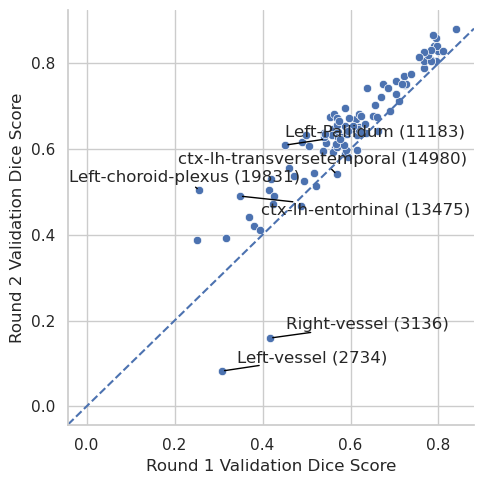

In [221]:
k=3
merged = round1_df.merge(round2_finetune_df, how = 'inner', on='label', suffixes=['_round1', '_round2'])
merged['is_cortex'] = merged['label_name'].str.startswith('ctx-')
to_plot = merged.copy()
to_plot['difference'] = to_plot['val_dice_score_round2'] - to_plot['val_dice_score_round1']
to_plot['is_lowest_k'] = to_plot['difference'] <= to_plot['difference'].nsmallest(k).max()
to_plot['is_highest_k'] = to_plot['difference'] >= to_plot['difference'].nlargest(k).min()
to_plot['combined_mask'] = to_plot['is_lowest_k'] | to_plot['is_highest_k'] | (to_plot['val_dice_score_round1'] <= to_plot['val_dice_score_round1'].nsmallest(0).max())

to_plot['label_name'] = np.where(to_plot['combined_mask'], to_plot['label_name'] + f' (' + to_plot['num_samples_per_epoch'].astype(str) + ')', '')

sns.relplot(data = to_plot,
            x = 'val_dice_score_round1',
            y = 'val_dice_score_round2')


plt.axline((0, 0), slope=1, linestyle = '--')
plt.xlabel('Round 1 Validation Dice Score')
plt.ylabel('Round 2 Validation Dice Score')

texts = []
for _, x in to_plot.iterrows():
    if x['combined_mask']:
        texts.append(plt.text(x['val_dice_score_round1'], x['val_dice_score_round2'], x['label_name']))

adjust_text(texts, force_points = [4,4], arrowprops=dict(arrowstyle='-', color='black'))

Text(66.89042708333334, 0.5, 'Round 2 Validation Dice Score')

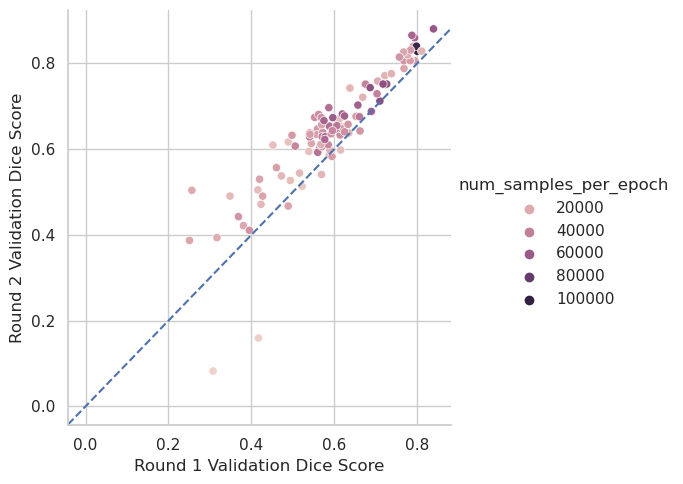

In [223]:
sns.relplot(data = to_plot,
            x = "val_dice_score_round1",
            y = "val_dice_score_round2",
            hue = "num_samples_per_epoch")
plt.axline((0, 0), slope=1, linestyle = '--')
plt.xlabel('Round 1 Validation Dice Score')
plt.ylabel('Round 2 Validation Dice Score')


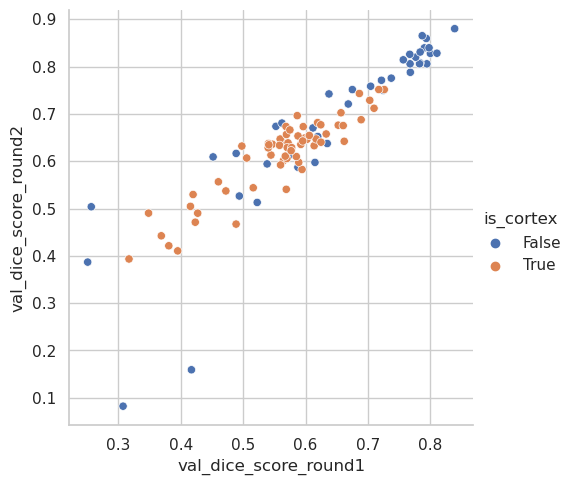

In [224]:
sns.relplot(data = to_plot,
            x = "val_dice_score_round1",
            y = "val_dice_score_round2",
            hue = "is_cortex")

median sample number is 28109.5
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_high v.s. True_high: t-test independent samples with Bonferroni correction, P_val=6.624e-08 stat=6.549e+00
False_low v.s. True_low: t-test independent samples with Bonferroni correction, P_val=4.010e-02 stat=2.404e+00


Text(36.875, 0.5, 'Round 2 Validation Dice Score')

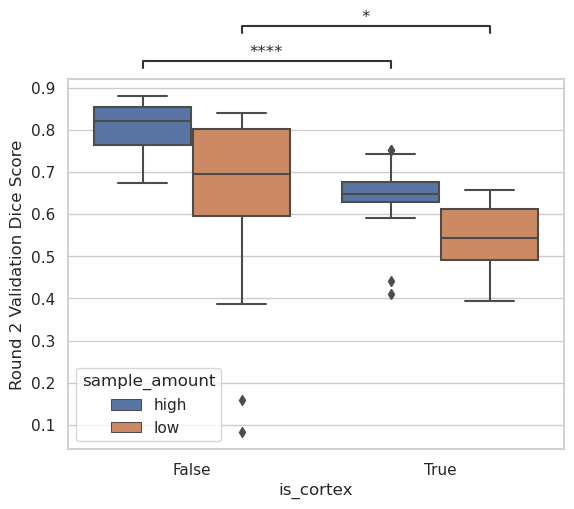

In [282]:
# group box plot:

# group1: not cortex
# group2: yes cortex

# subgroups: low samples and high samples (defined as <= or >= median)
to_plot_box = merged.copy()
to_plot_box = to_plot_box[['label', 'label_name', 'val_dice_score_round2', 'num_samples_per_epoch', 'is_cortex']]
median_num_samples = to_plot_box["num_samples_per_epoch"].median()
print(f'median sample number is {median_num_samples}')
to_plot_box['sample_amount'] = np.where(to_plot_box['num_samples_per_epoch'] >= median_num_samples, 'high', 'low')
#to_plot_box = pd.melt(to_plot_box, id_vars = ['label', 'label_name', 'is_cortex', 'num_samples_per_epoch'], value_vars = ['val_dice_score_round1', 'val_dice_score_round2'])

sns.boxplot(x="is_cortex", hue = 'sample_amount', y = 'val_dice_score_round2', data = to_plot_box)  
statannot.add_stat_annotation(
    plt.gca(),
    data=to_plot_box,
    x='is_cortex',
    y='val_dice_score_round2',
    hue='sample_amount',
    box_pairs=[
        ((True, "high"), (False, "high")),
        ((True, "low"), (False, "low")),
    ],
    test="t-test_ind",
    text_format="star",
    loc="outside",
)

plt.ylabel('Round 2 Validation Dice Score')

In [258]:
print(merged['val_dice_score_round1'].median())
print(merged['val_dice_score_round2'].median())

0.58833858
0.6424119472503662


median sample number is 28109.5
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

high v.s. low: t-test independent samples with Bonferroni correction, P_val=5.248e-01 stat=6.381e-01


Text(24.125, 0.5, 'Round 2 DICE - Round 1 DICE')

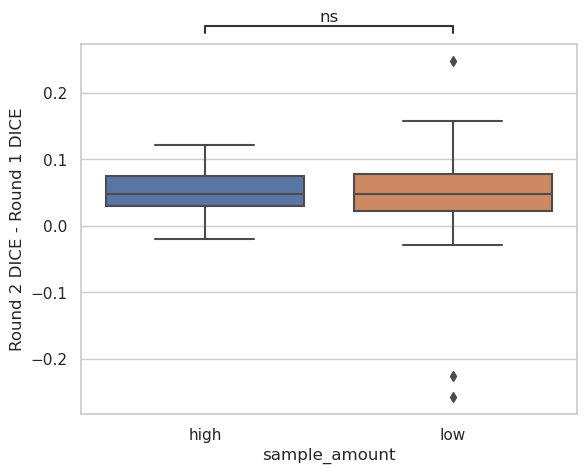

In [279]:
# group box plot:

# group1: low samples
# group2: high samples

# subgroups: round1 and round2
to_plot_box = merged.copy()
to_plot_box = to_plot_box[['label', 'label_name', 'val_dice_score_round1', 'val_dice_score_round2', 'num_samples_per_epoch']]
median_num_samples = to_plot_box["num_samples_per_epoch"].quantile(q=0.5)
print(f'median sample number is {median_num_samples}')
to_plot_box['sample_amount'] = np.where(to_plot_box['num_samples_per_epoch'] >= median_num_samples, 'high', 'low')
to_plot_box['difference'] = to_plot_box['val_dice_score_round2'] - to_plot_box['val_dice_score_round1']
#to_plot_box = pd.melt(to_plot_box, id_vars = ['label', 'label_name', 'sample_amount'], value_vars = ['val_dice_score_round1', 'val_dice_score_round2'], value_name = 'val dice score')
#dict_map = {'val_dice_score_round1': 'Round 1 (Multi-task)', 'val_dice_score_round2': 'Round 2 (Single-task)'}
#to_plot_box['variable'] = to_plot_box['variable'].map(dict_map)

sns.boxplot(x='sample_amount', y = 'difference', data = to_plot_box)
statannot.add_stat_annotation(
    plt.gca(),
    data=to_plot_box,
    x='sample_amount',
    y='difference',
    box_pairs=[
        ('high', 'low')
    ],
    test="t-test_ind",
    text_format="star",
    loc="outside",
)

plt.ylabel('Round 2 DICE - Round 1 DICE')